In [14]:
from sdid import sdid
import pandas as pd
from get_data import quota, california_prop99

In [15]:
a = sdid(california_prop99(), "State", "Year", "treated", "PacksPerCapita")
print(a)

-15.60383


In [16]:
b = sdid(quota(), "country", "year", "quota", "womparl")
print(b)

8.03402


In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from get_data import quota, california_prop99
from utils import panel_matrices, collapse_form, sum_normalize, att_mult
from solver import fw_step, sc_weight_fw, sc_weight_covariates
from sdid import sparsify_function, varianza, sdid
from plots import plot_outcomes, plot_weights
# sdid(quota(), "country", "year", "quota", "womparl", ["lnmmrt", "lngdp"])

In [2]:
qta = quota()
drop_country = [
	"Algeria", "Kenya", "Samoa", "Swaziland", "Tanzania"
]
quota_if = qta.query("country not in @drop_country")
c = sdid(quota(), "country", "year", "quota", "womparl")

In [3]:
cal1 = sdid(california_prop99(), "State", "Year", "treated", "PacksPerCapita")
cal1["att"]

-15.60383

## Plots

d:\work\synthdid.py\src\plots.py:135: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(units, rotation = 90, fontsize = ns);


[<Figure size 640x480 with 1 Axes>]

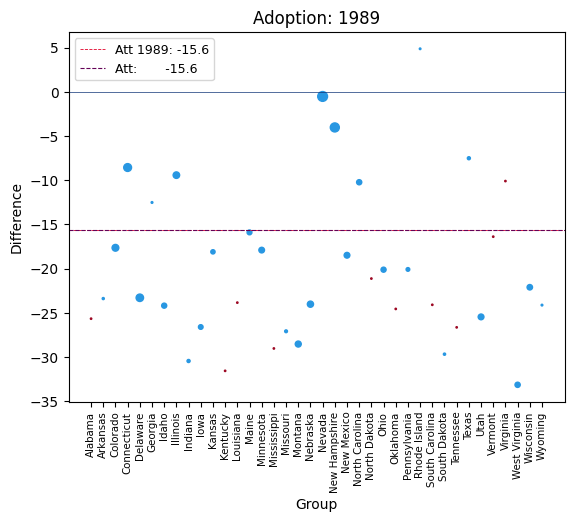

In [17]:
plot_weights(cal1)

In [ ]:
plot_outcomes(c)

In [8]:
# import openpyxl

omega_tbl = pd.DataFrame(c["weights"]["omega"]).T
omega_tbl.to_csv("omega_quota.csv")


lambda_tbl = pd.DataFrame(c["weights"]["lambda"]).T
lambda_tbl.to_csv("lambda_quota.csv")

In [9]:
lambda_tbl

,0,1,2,3,4,5,6
0,0.000000,0.000000,0.000000,0.000000,0.001491,0.039638,0.000000
1,0.183279,0.186924,0.184227,0.155157,0.087099,0.000000,0.007611
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.001999,0.000000,0.028401
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.168830,0.113092,0.088752,0.055279,0.000000,0.000000,0.000000
9,0.647892,0.122193,0.056632,0.025027,0.000000,0.000000,0.000000


d:\work\synthdid.py\src\plots.py:135: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(units, rotation = 90, fontsize = ns);


[<Figure size 640x480 with 1 Axes>]

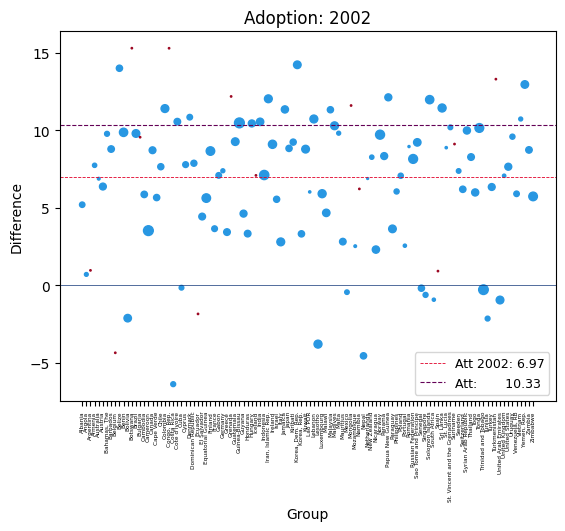

In [12]:
plot_weights(c, times = [2002])

In [214]:
plot_weights(c)

0


ValueError: operands could not be broadcast together with shapes (26,) (25,) 

In [213]:
def plot_weights(estimate, unit_filter = None, times = None, time_title_cb = int):

    weights = estimate["weights"]
    table_result = estimate["att_info"]
    lambda_wg = weights["lambda"]
    omega_wg = weights["omega"]
    N0s = table_result.N0
    T0s = table_result.T0
    T1s = table_result.T1
    N1s = table_result.N1
    atts = np.round(table_result.att_time, 2)
    y_units = estimate["Y_units"]
    Y_setups = estimate["Y_beta"]

    if times is None:
        times = table_result.time

    real_att = np.round(estimate["att"], 2)

    # label_size = 

    plots = []
    for i, time in enumerate(times):
        print(i)
        units = y_units[i][:N0]
        Y = Y_setups[i].to_numpy()
        
        ls = np.arange(0, len(units), 1)
        ls_rel = np.interp(ls, (ls.min(), ls.max()), (9, 4))#[len(weights_dots) - 1]
        ns = ls_rel[len(units) - 1]
        lambda_hat = lambda_wg[i]
        omega_hat = omega_wg[i]
        lambda_pre = np.concatenate((lambda_hat, np.full(T1, 0)))
        lambda_post = np.concatenate((np.full(T0, 0), np.full(T1, 1 / T1)))
        omega_control = np.concatenate((omega_hat, np.full(N1, 0)))
        omega_treat = np.concatenate((np.full(N0, 0), np.full(N1, 1 / N1)))

        difs = np.dot(omega_treat, Y).dot(lambda_post - lambda_pre) -\
            np.dot(Y[:N0, :], (lambda_post - lambda_pre))
        size_dot = omega_hat / np.max(omega_hat) * 10
        color_dot = np.where(size_dot == 0, "#9D0924", "#2897E2")
        # shape_dot = np.where(size_dot == 0, ".", "v")
        spaces = " " * (len(str(int(times[i]))) + 1)
        import matplotlib.pyplot as plt

        size_dot = np.interp(size_dot, (size_dot.min(), size_dot.max()), (1, 50))

        weights_dots = pd.DataFrame({
            "unit": units, "difs": difs, "size": size_dot, 
            "shape": shape_dot, "color": color_dot
            })

        if unit_filter is not None:
            weights_dots = weights_dots.query("unit in @unit_filter")
            size_dot = weights_dots.size
            size_dot = np.interp(size_dot, (size_dot.min(), size_dot.max()), (1, 50))
            weights_dots["size_dot"] = size_dot
            
            ns = ls_rel[len(unit_filter) - 1]

        fig, ax = plt.subplots()

        ax.scatter("unit", "difs", data = weights_dots, s = "size", c = "color", label = "")
        # ax.scatter("unit", "difs", data = weights_dots, s = "size", color = "color", marker=shape_dot)
        ax.set_xticklabels(units, rotation = 90, fontsize = ns);
        ax.set_xlabel("Group")
        ax.set_ylabel("Difference")
        ax.set_title("Adoption: " + str(time_title_cb(times[i])))
        ax.axhline(y=atts[i], linestyle = "--", color = "#E00029", lw = .6, label = f"Att {time_title_cb(times[i])}: {atts[i]}")
        ax.axhline(y=estimate["att"], linestyle = "--", color = "#640257", lw = .8, label = f"Att: {spaces} {real_att}")
        ax.legend(fontsize = 9)
        if weights_dots.difs.max() > 0 and weights_dots.difs.min() < 0:
            ax.axhline(y=0, lw = .5, c = "#0D3276")
            
        plots.append(fig)
    return plots

1

1

In [270]:
times = None
# unit_filter = None
unit_filter = np.random.choice(units, 200)

time_title_cb = int
weights = estimate["weights"]
table_result = estimate["att_info"]
lambda_wg = weights["lambda"]
omega_wg = weights["omega"]
N0s = table_result.N0
T0s = table_result.T0
T1s = table_result.T1
N1s = table_result.N1
atts = np.round(table_result.att_time, 2)
y_units = estimate["Y_units"]
Y_setups = estimate["Y_beta"]

if times is None:
	times = table_result.time

real_att = np.round(estimate["att"], 2)

# label_size 
ls = np.arange(0, 200, 1)
ls_rel = np.interp(ls, (ls.min(), ls.max()), (9, 4))#[len(weights_dots) - 1]
ns = ls_rel[0]
if unit_filter is not None: 
    l_unit_f = len(unit_filter)
    if l_unit_f > 199:
        ns = ls_rel[199]
    ns = ls_rel[l_unit_f - 1]

4.0


C:\Users\Jhon\AppData\Local\Temp\ipykernel_13256\4127895346.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(units, rotation = 90, fontsize = ns);
C:\Users\Jhon\AppData\Local\Temp\ipykernel_13256\4127895346.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(units, rotation = 90, fontsize = ns);


[<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>]

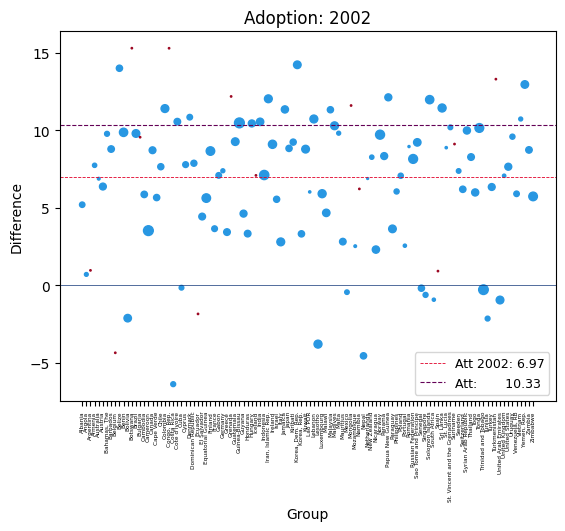

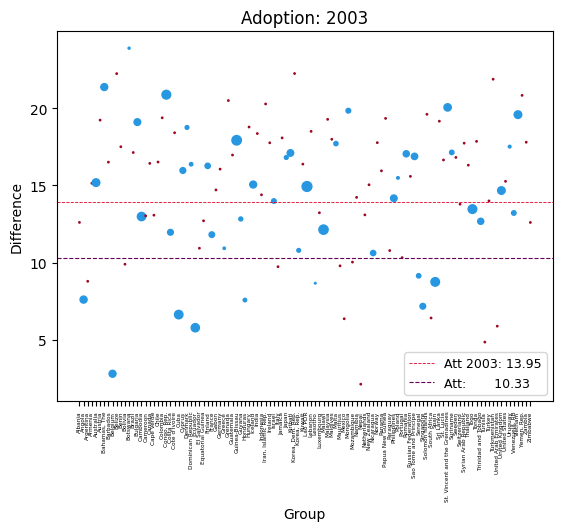

In [287]:
def plot_weights(estimate, unit_filter=None, times=None, time_title_cb=int):
    weights = estimate["weights"]
    table_result = estimate["att_info"]
    lambda_wg = weights["lambda"]
    omega_wg = weights["omega"]
    N0s = table_result.N0
    T0s = table_result.T0
    T1s = table_result.T1
    N1s = table_result.N1
    atts = np.round(table_result.att_time, 2)
    y_units = estimate["Y_units"]
    Y_setups = estimate["Y_beta"]

    if times is None:
        times = table_result.time

    real_att = np.round(estimate["att"], 2)

	# label_size 
    ls = np.arange(0, 114, 1)
    ls_rel = np.interp(ls, (ls.min(), ls.max()), (9, 4))#[len(weights_dots) - 1]
    # ns = ls_rel[0]
    if unit_filter is not None: 
        l_unit_f = len(unit_filter)
        if l_unit_f > 114:
            ns = ls_rel[113]
        ns = ls_rel[l_unit_f - 1]
    plots = []
    def plot_times(i):
        N0, T0, N1, T1 = N0s[i], T0s[i], N1s[i], T1s[i]

        units = y_units[i][:N0]
        ns = ls_rel[len(units) - 1]
        Y = Y_setups[i].to_numpy()

        lambda_hat = lambda_wg[i]
        omega_hat = omega_wg[i]
        lambda_pre = np.concatenate((lambda_hat, np.full(T1, 0)))
        lambda_post = np.concatenate((np.full(T0, 0), np.full(T1, 1 / T1)))
        omega_control = np.concatenate((omega_hat, np.full(N1, 0)))
        omega_treat = np.concatenate((np.full(N0, 0), np.full(N1, 1 / N1)))

        difs = np.dot(omega_treat, Y).dot(lambda_post - lambda_pre) -\
            np.dot(Y[:N0, :], (lambda_post - lambda_pre))
        size_dot = omega_hat / np.max(omega_hat) * 10
        color_dot = np.where(size_dot == 0, "#9D0924", "#2897E2")
        # shape_dot = np.where(size_dot == 0, ".", "v")
        spaces = " " * (len(str(int(times[i]))) + 1)
        import matplotlib.pyplot as plt

        size_dot = np.interp(size_dot, (size_dot.min(), size_dot.max()), (1, 50))

        weights_dots = pd.DataFrame({
            "unit": units, "difs": difs, "size": size_dot, 
            "shape": shape_dot, "color": color_dot
            })

        if unit_filter is not None:
            weights_dots = weights_dots.query("unit in @unit_filter")
            size_dot = weights_dots.size
            size_dot = np.interp(size_dot, (size_dot.min(), size_dot.max()), (1, 50))
            weights_dots["size_dot"] = size_dot

        fig, ax = plt.subplots()

        ax.scatter("unit", "difs", data = weights_dots, s = "size", c = "color", label = "")
        # ax.scatter("unit", "difs", data = weights_dots, s = "size", color = "color", marker=shape_dot)
        ax.set_xticklabels(units, rotation = 90, fontsize = ns);
        ax.set_xlabel("Group")
        ax.set_ylabel("Difference")
        ax.set_title("Adoption: " + str(time_title_cb(times[i])))
        ax.axhline(y=atts[i], linestyle = "--", color = "#E00029", lw = .6, label = f"Att {time_title_cb(times[i])}: {atts[i]}")
        ax.axhline(y=estimate["att"], linestyle = "--", color = "#640257", lw = .8, label = f"Att: {spaces} {real_att}")
        ax.legend(fontsize = 9)
        if weights_dots.difs.max() > 0 and weights_dots.difs.min() < 0:
            ax.axhline(y=0, lw = .5, c = "#0D3276")
        plots.append(fig)

    for i, time in enumerate(times):
        plot_times(i)
    return plots

1
plot_weights(c)

In [284]:
def plot_weights(estimate, unit_filter=None, times=None, time_title_cb=int):
    weights = estimate["weights"]
    table_result = estimate["att_info"]
    lambda_wg = weights["lambda"]
    omega_wg = weights["omega"]
    N0s = table_result.N0
    T0s = table_result.T0
    T1s = table_result.T1
    N1s = table_result.N1
    atts = np.round(table_result.att_time, 2)
    y_units = estimate["Y_units"]
    Y_setups = estimate["Y_beta"]

    if times is None:
        times = table_result.time

    real_att = np.round(estimate["att"], 2)

	# label_size 
    ls = np.arange(0, 114, 1)
    ls_rel = np.interp(ls, (ls.min(), ls.max()), (9, 4))#[len(weights_dots) - 1]
    ns = ls_rel[0]
    if unit_filter is not None: 
        l_unit_f = len(unit_filter)
        if l_unit_f > 114:
            ns = ls_rel[113]
        ns = ls_rel[l_unit_f - 1]
    plots = []
    def plot_times(i):
        N0, T0, N1, T1 = N0s[i], T0s[i], N1s[i], T1s[i]

        units = y_units[i][:N0]
        Y = Y_setups[i].to_numpy()

        lambda_hat = lambda_wg[i]
        omega_hat = omega_wg[i]
        lambda_pre = np.concatenate((lambda_hat, np.full(T1, 0)))
        lambda_post = np.concatenate((np.full(T0, 0), np.full(T1, 1 / T1)))
        omega_control = np.concatenate((omega_hat, np.full(N1, 0)))
        omega_treat = np.concatenate((np.full(N0, 0), np.full(N1, 1 / N1)))

        difs = np.dot(omega_treat, Y).dot(lambda_post - lambda_pre) -\
            np.dot(Y[:N0, :], (lambda_post - lambda_pre))
        size_dot = omega_hat / np.max(omega_hat) * 10
        color_dot = np.where(size_dot == 0, "#9D0924", "#2897E2")
        # shape_dot = np.where(size_dot == 0, ".", "v")
        spaces = " " * (len(str(int(times[i]))) + 1)
        import matplotlib.pyplot as plt

        size_dot = np.interp(size_dot, (size_dot.min(), size_dot.max()), (1, 50))

        weights_dots = pd.DataFrame({
            "unit": units, "difs": difs, "size": size_dot, 
            "shape": shape_dot, "color": color_dot
            })

        if unit_filter is not None:
            weights_dots = weights_dots.query("unit in @unit_filter")
            size_dot = weights_dots.size
            size_dot = np.interp(size_dot, (size_dot.min(), size_dot.max()), (1, 50))
            weights_dots["size_dot"] = size_dot

        fig, ax = plt.subplots()

        ax.scatter("unit", "difs", data = weights_dots, s = "size", c = "color", label = "")
        # ax.scatter("unit", "difs", data = weights_dots, s = "size", color = "color", marker=shape_dot)
        ax.set_xticklabels(units, rotation = 90, fontsize = ns);
        ax.set_xlabel("Group")
        ax.set_ylabel("Difference")
        ax.set_title("Adoption: " + str(time_title_cb(times[i])))
        ax.axhline(y=atts[i], linestyle = "--", color = "#E00029", lw = .6, label = f"Att {time_title_cb(times[i])}: {atts[i]}")
        ax.axhline(y=estimate["att"], linestyle = "--", color = "#640257", lw = .8, label = f"Att: {spaces} {real_att}")
        ax.legend(fontsize = 9)
        if weights_dots.difs.max() > 0 and weights_dots.difs.min() < 0:
            ax.axhline(y=0, lw = .5, c = "#0D3276")
        plots.append(fig)

    for i, time in enumerate(times):
        plot_times(i)
    return plots

1

1

C:\Users\Jhon\AppData\Local\Temp\ipykernel_13256\3139580989.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weights_dots["size_dot"] = size_dot
C:\Users\Jhon\AppData\Local\Temp\ipykernel_13256\3139580989.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(units, rotation = 90, fontsize = ns);
C:\Users\Jhon\AppData\Local\Temp\ipykernel_13256\3139580989.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weights_dots["size_dot"] = size_dot
C:\Users\Jhon

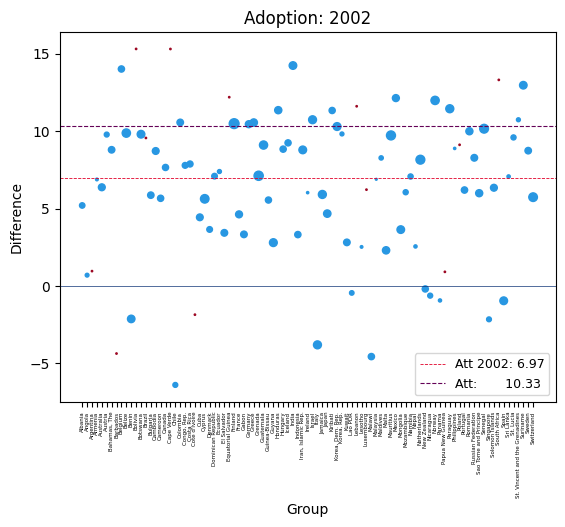

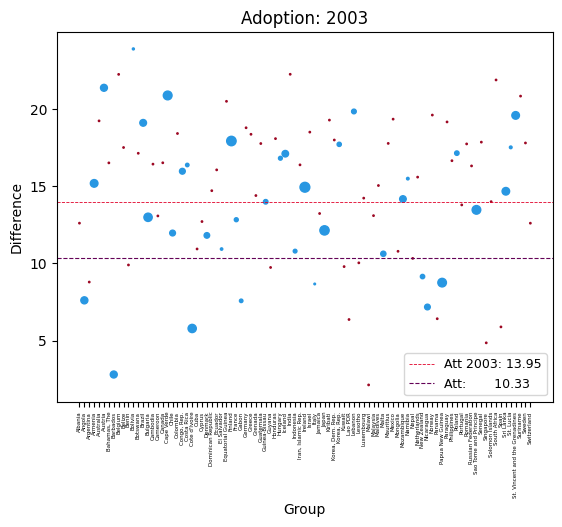

In [280]:


plots = []


def plot_times(i):
    # i, time = enumerate(times)
    N0, T0, N1, T1 = N0s[i], T0s[i], N1s[i], T1s[i]

    units = y_units[i][:N0]
    Y = Y_setups[i].to_numpy()

    lambda_hat = lambda_wg[i]
    omega_hat = omega_wg[i]
    lambda_pre = np.concatenate((lambda_hat, np.full(T1, 0)))
    lambda_post = np.concatenate((np.full(T0, 0), np.full(T1, 1 / T1)))
    omega_control = np.concatenate((omega_hat, np.full(N1, 0)))
    omega_treat = np.concatenate((np.full(N0, 0), np.full(N1, 1 / N1)))

    difs = np.dot(omega_treat, Y).dot(lambda_post - lambda_pre) -\
        np.dot(Y[:N0, :], (lambda_post - lambda_pre))
    size_dot = omega_hat / np.max(omega_hat) * 10
    color_dot = np.where(size_dot == 0, "#9D0924", "#2897E2")
    # shape_dot = np.where(size_dot == 0, ".", "v")
    spaces = " " * (len(str(int(times[i]))) + 1)
    import matplotlib.pyplot as plt

    size_dot = np.interp(size_dot, (size_dot.min(), size_dot.max()), (1, 50))

    weights_dots = pd.DataFrame({
        "unit": units, "difs": difs, "size": size_dot, 
        "shape": shape_dot, "color": color_dot
        })

    if unit_filter is not None:
        weights_dots = weights_dots.query("unit in @unit_filter")
        size_dot = weights_dots.size
        size_dot = np.interp(size_dot, (size_dot.min(), size_dot.max()), (1, 50))
        weights_dots["size_dot"] = size_dot

    fig, ax = plt.subplots()

    ax.scatter("unit", "difs", data = weights_dots, s = "size", c = "color", label = "")
    # ax.scatter("unit", "difs", data = weights_dots, s = "size", color = "color", marker=shape_dot)
    ax.set_xticklabels(units, rotation = 90, fontsize = ns);
    ax.set_xlabel("Group")
    ax.set_ylabel("Difference")
    ax.set_title("Adoption: " + str(time_title_cb(times[i])))
    ax.axhline(y=atts[i], linestyle = "--", color = "#E00029", lw = .6, label = f"Att {time_title_cb(times[i])}: {atts[i]}")
    ax.axhline(y=estimate["att"], linestyle = "--", color = "#640257", lw = .8, label = f"Att: {spaces} {real_att}")
    ax.legend(fontsize = 9)
    if weights_dots.difs.max() > 0 and weights_dots.difs.min() < 0:
        ax.axhline(y=0, lw = .5, c = "#0D3276")
    plots.append(fig)

for i, time in enumerate(times):
    plot_times(i)
